# Complex Network Analysis

C-elegans worm connectome dataset, found at https://manliodedomenico.com/data.php. Consists of a multilayer network with three layers and the connections therein.

In [1]:
import networkx as nx
import numpy as np
import pickle
import matplotlib.pyplot as plt

The network data file has the notation `layer nodei nodef weight`. Knowing this we can extract the information into each of the three layers.

In [2]:
path = 'CElegans_Multiplex_Neuronal/CElegans_Multiplex_Neuronal/Dataset/celegans_connectome_multiplex.edges'

In [3]:
with open(path, 'r') as f:
    multiplex = f.readlines()
    
nodes = set()
layers = set()
edges = set()

for edge in multiplex:
    comp = edge.split(' ')

    layers.add(comp[0])
    nodes.add(comp[1])
    nodes.add(comp[2])
    edges.add((str(comp[0]), comp[1], comp[2], float(comp[3].replace('\n', '')))) # remove \n from weight

In [4]:
print('Layers, nodes, edges: ', len(layers), len(nodes), len(edges))

Layers, nodes, edges:  3 279 5863


In [5]:
with open('CElegans_Multiplex_Neuronal/CElegans_Multiplex_Neuronal/Dataset/celegans_connectome_layers.txt', 'r') as g:
    lays = g.read()
    print(lays)

layerID layerLabel
1 ElectrJ
2 MonoSyn
3 PolySyn



We now create each of the layers as entries in a dictionary, and save it.

In [6]:
N = len(nodes)
Glays = {int(m): nx.DiGraph() for m in layers}

Glays['aggr'] = nx.DiGraph()

for k in edges:
    Glays[int(k[0])].add_edge(k[1], k[2], weight = k[3])

    Glays['aggr'].add_edge(k[1], k[2], weight = k[3])

View the adjacency matrices of each layer

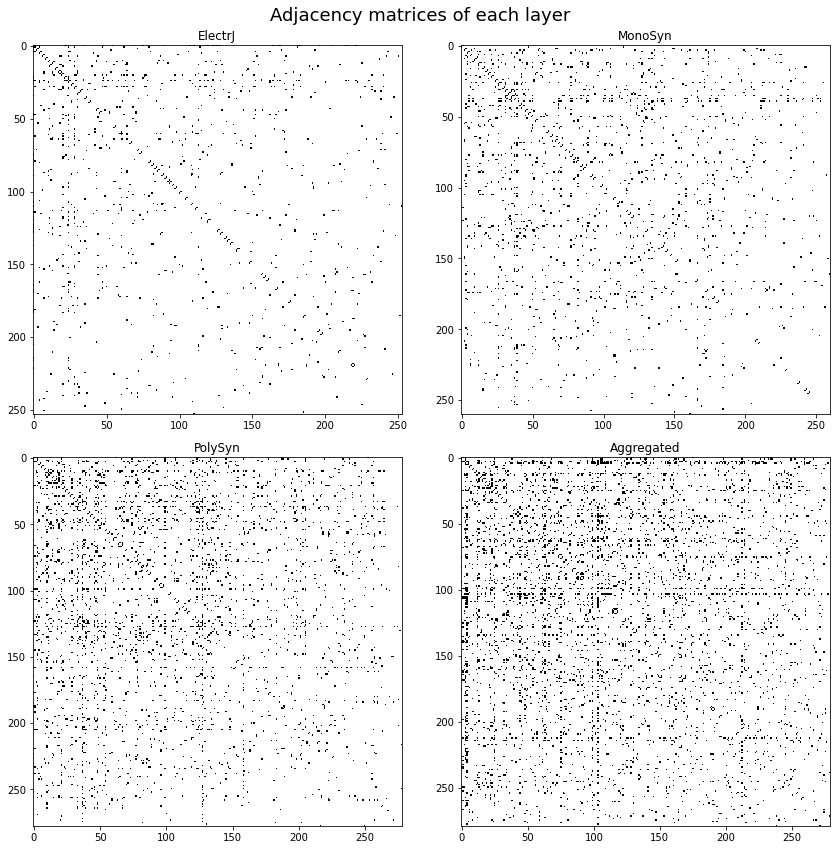

In [7]:
fig, ax = plt.subplots(2,2, figsize = (12,12))

fig.suptitle('Adjacency matrices of each layer', fontsize = 18)

names = {1: "ElectrJ",  2: "MonoSyn", 3: "PolySyn", 'aggr': "Aggregated"}
pos = {1: (0,0),  2: (0,1), 3: (1,0), 'aggr': (1,1)}

for i, G in Glays.items():

    adjacency_matrix = nx.to_numpy_matrix(G, dtype=bool)
    
    x, y = pos[i]
    
    #Plot adjacency matrix in toned-down black and white
    ax[x,y].set_title(names[i])
    ax[x,y].imshow(adjacency_matrix, cmap="Greys", interpolation="none")
    
plt.tight_layout()

plt.savefig('Figures/adjacency_matrices.png', facecolor='w', transparent=False)

In [8]:
# Pickle the result
dataset = 'CElegans_multiplex.pkl'
with open(dataset, 'wb') as f:
    pickle.dump(Glays, f)

## Basic stats

In [9]:
for i, G in Glays.items():
    print('--', i, '--')
    print('Nodes, edges: ', len(G.nodes), len(G.edges))
    print('Connectivity:', nx.is_strongly_connected(G), nx.is_weakly_connected(G))
    print('Clustering: ', nx.average_clustering(G))
    
    lcc = max(nx.strongly_connected_components(G), key=len)
    S = G.subgraph(lcc).copy()
    print('Diameter: ', nx.diameter(S))

-- 1 --
Nodes, edges:  253 1031
Connectivity: False False
Clustering:  0.20236567170385783
Diameter:  12
-- 2 --
Nodes, edges:  260 1639
Connectivity: False False
Clustering:  0.17077590736791387
Diameter:  9
-- 3 --
Nodes, edges:  278 3193
Connectivity: False True
Clustering:  0.2722023233661824
Diameter:  7
-- aggr --
Nodes, edges:  279 4577
Connectivity: True True
Clustering:  0.33713399908901953
Diameter:  5


## Scale-freeness

In [10]:
def degree_histogram(G, in_out):
    """
    Return a list of the frequency of each degree value (a histogram).
    """
    
    nodes = G.nodes()
    if in_out == 'in':
        in_deg = dict(G.in_degree())
        degrees = in_deg.values()
    elif in_out == 'out':
        out_deg = dict(G.out_degree())
        degrees = out_deg.values()
        
    dmax = max(degrees) + 1
    freq = [0 for d in range(dmax)]
    
    for d in degrees:
        freq[d] += 1
    
    return freq

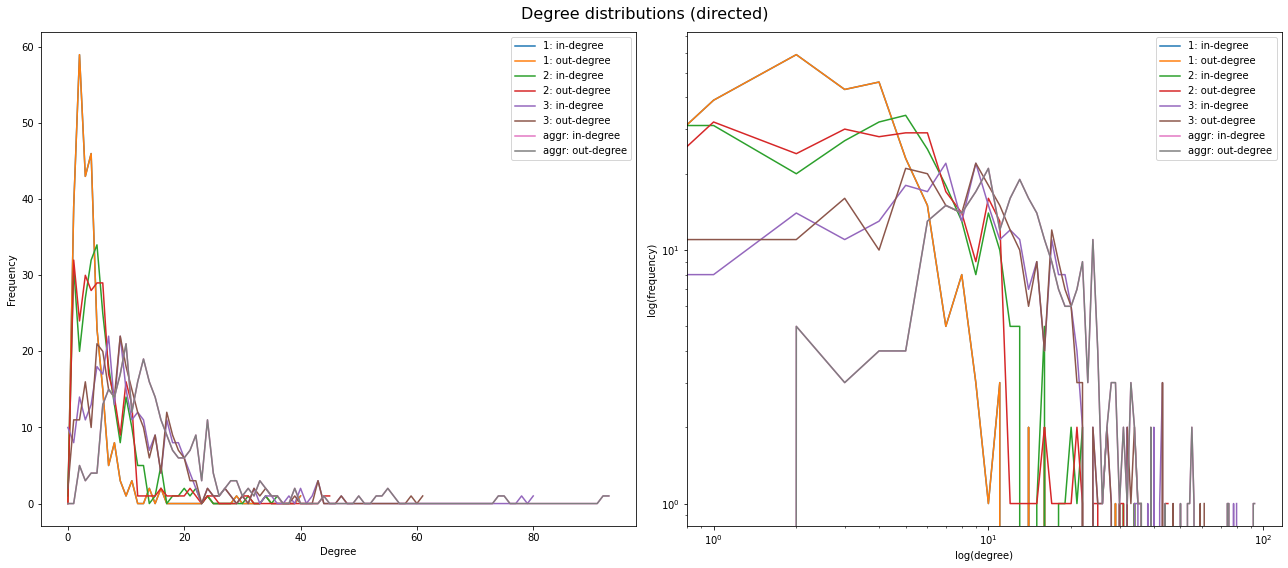

In [11]:
fig, ax = plt.subplots(1, 2, figsize=(18, 8)) 

fig.suptitle('Degree distributions (directed)', fontsize = 16)

for i, G in Glays.items():

    in_degree_freq = degree_histogram(G, in_out='in')
    out_degree_freq = degree_histogram(G, in_out='out')

    ax[0].plot(range(len(in_degree_freq)), in_degree_freq, label=f'{i}: in-degree') 
    ax[0].plot(range(len(out_degree_freq)), out_degree_freq, label=f'{i}: out-degree')
    
    ax[1].loglog(range(len(in_degree_freq)), in_degree_freq, label=f'{i}: in-degree') 
    ax[1].loglog(range(len(out_degree_freq)), out_degree_freq, label=f'{i}: out-degree')

ax[0].set_xlabel('Degree')
ax[0].set_ylabel('Frequency')
ax[0].legend()

ax[1].set_xlabel('log(degree)')
ax[1].set_ylabel('log(frequency)')
ax[1].legend()

plt.tight_layout()

plt.savefig('Figures/degree_distrib_dir.png', facecolor='white', transparent=False)

These do not feature great scale-free properties (in fact if we try to compute lines of best fit for them we encounter many errors because of the null logarithms).

If we ignore directedness, we find almost the same behavior:

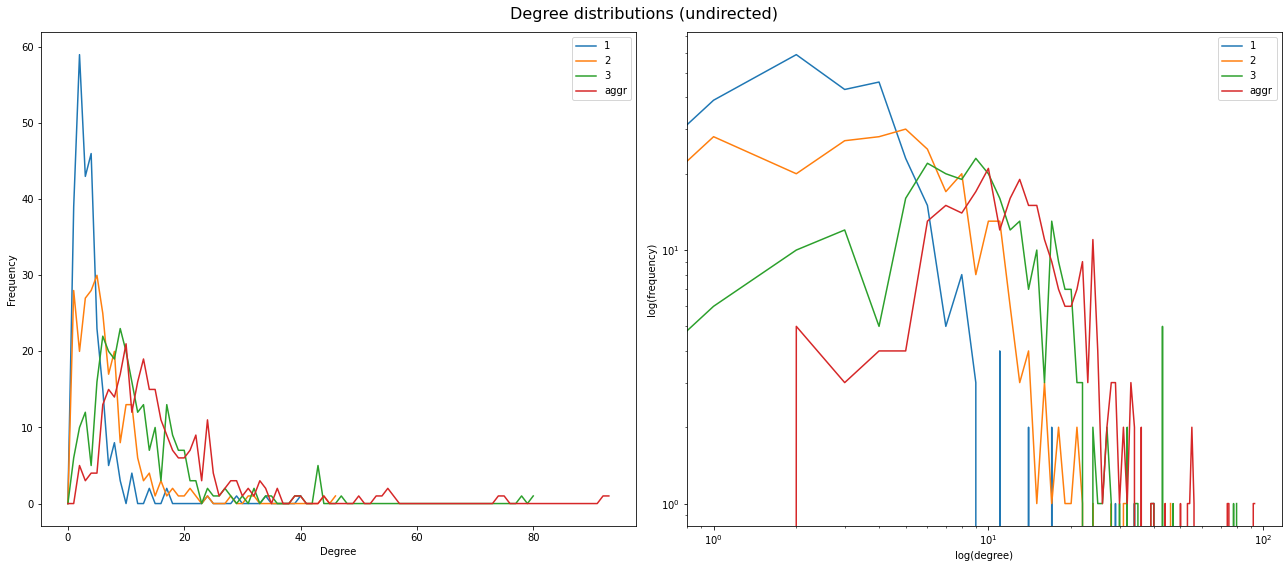

In [12]:
fig, ax = plt.subplots(1, 2, figsize=(18, 8)) 

fig.suptitle('Degree distributions (undirected)', fontsize = 16)

for i, G in Glays.items():

    undG = nx.Graph(G)
    hist = nx.degree_histogram(undG)

    ax[0].plot(range(len(hist)), hist, label=f'{i}') 
    ax[1].loglog(range(len(hist)), hist, label=f'{i}')

ax[0].set_xlabel('Degree')
ax[0].set_ylabel('Frequency')
ax[0].legend()

ax[1].set_xlabel('log(degree)')
ax[1].set_ylabel('log(frequency)')
ax[1].legend()

plt.tight_layout()

plt.savefig('Figures/degree_distrib_undir.png', facecolor='white', transparent=False)

## Centrality measures

In [13]:
def top5(cent):
    """
    Given a dictionary node-centrality score, print the top5 ranking
    """
    
    C = sorted(cent, key=cent.get, reverse=True)[:5]
    ranking = {key: cent[key] for key in C}
    
    print(ranking)
    
    return ranking

### In/Out-Degree

In [14]:
rank = {}

for i, G in Glays.items():
    print('--', i, '--')
    
    cent = nx.in_degree_centrality(G)
    
    ranking = top5(cent)
    rank[i] = list(ranking.keys())
    print()

# Display ready for latex
print(f"{rank[1][0]} & {rank[2][0]} & {rank[3][0]} & {rank['aggr'][0]}\\\ \n"
      + f"{rank[1][1]} & {rank[2][1]} & {rank[3][1]} & {rank['aggr'][1]}\\\ \n"
      + f"{rank[1][2]} & {rank[2][2]} & {rank[3][2]} & {rank['aggr'][2]}\\\ \n"
      + f"{rank[1][3]} & {rank[2][3]} & {rank[3][3]} & {rank['aggr'][3]}\\\ \n"
      + f"{rank[1][4]} & {rank[2][4]} & {rank[3][4]} & {rank['aggr'][4]}\\\ ")

-- 1 --
{'54': 0.15873015873015872, '55': 0.1349206349206349, '57': 0.11507936507936507, '56': 0.09523809523809523, '168': 0.06349206349206349}

-- 2 --
{'54': 0.138996138996139, '55': 0.1312741312741313, '56': 0.11969111969111969, '151': 0.09266409266409267, '166': 0.08494208494208494}

-- 3 --
{'55': 0.2888086642599278, '54': 0.2815884476534296, '60': 0.16967509025270758, '59': 0.1552346570397112, '61': 0.1552346570397112}

-- aggr --
{'55': 0.33453237410071945, '54': 0.33093525179856115, '56': 0.2697841726618705, '57': 0.26618705035971224, '61': 0.20143884892086333}

54 & 54 & 55 & 55\\ 
55 & 55 & 54 & 54\\ 
57 & 56 & 60 & 56\\ 
56 & 151 & 59 & 57\\ 
168 & 166 & 61 & 61\\ 


In [15]:
rank = {}

for i, G in Glays.items():
    print('--', i, '--')
    
    cent = nx.out_degree_centrality(G)
    
    ranking = top5(cent)
    rank[i] = list(ranking.keys())
    print()

# Display ready for latex
print(f"{rank[1][0]} & {rank[2][0]} & {rank[3][0]} & {rank['aggr'][0]}\\\ \n"
      + f"{rank[1][1]} & {rank[2][1]} & {rank[3][1]} & {rank['aggr'][1]}\\\ \n"
      + f"{rank[1][2]} & {rank[2][2]} & {rank[3][2]} & {rank['aggr'][2]}\\\ \n"
      + f"{rank[1][3]} & {rank[2][3]} & {rank[3][3]} & {rank['aggr'][3]}\\\ \n"
      + f"{rank[1][4]} & {rank[2][4]} & {rank[3][4]} & {rank['aggr'][4]}\\\ ")

-- 1 --
{'54': 0.15873015873015872, '55': 0.1349206349206349, '57': 0.11507936507936507, '56': 0.09523809523809523, '168': 0.06349206349206349}

-- 2 --
{'55': 0.17374517374517376, '54': 0.16988416988416988, '151': 0.11969111969111969, '56': 0.11583011583011583, '152': 0.09652509652509653}

-- 3 --
{'54': 0.22021660649819497, '55': 0.21299638989169675, '60': 0.16967509025270758, '59': 0.1552346570397112, '61': 0.1552346570397112}

-- aggr --
{'55': 0.33453237410071945, '54': 0.33093525179856115, '56': 0.2697841726618705, '57': 0.26618705035971224, '61': 0.20143884892086333}

54 & 55 & 54 & 55\\ 
55 & 54 & 55 & 54\\ 
57 & 151 & 60 & 56\\ 
56 & 56 & 59 & 57\\ 
168 & 152 & 61 & 61\\ 


### Betweeness/closeness

In [16]:
rank = {}

for i, G in Glays.items():
    print('--', i, '--')
    
    cent = nx.betweenness_centrality(G)
    
    ranking = top5(cent)
    rank[i] = list(ranking.keys())
    print()

# Display ready for latex
print(f"{rank[1][0]} & {rank[2][0]} & {rank[3][0]} & {rank['aggr'][0]}\\\ \n"
      + f"{rank[1][1]} & {rank[2][1]} & {rank[3][1]} & {rank['aggr'][1]}\\\ \n"
      + f"{rank[1][2]} & {rank[2][2]} & {rank[3][2]} & {rank['aggr'][2]}\\\ \n"
      + f"{rank[1][3]} & {rank[2][3]} & {rank[3][3]} & {rank['aggr'][3]}\\\ \n"
      + f"{rank[1][4]} & {rank[2][4]} & {rank[3][4]} & {rank['aggr'][4]}\\\ ")

-- 1 --
{'54': 0.21615885885745775, '57': 0.17107868908071278, '175': 0.10786981760147034, '55': 0.10052380792825275, '69': 0.09841626800516899}

-- 2 --
{'54': 0.12579728722824204, '55': 0.10874078461791604, '56': 0.09495137821698126, '166': 0.07516112722872517, '61': 0.06786783207750186}

-- 3 --
{'55': 0.12150683349284237, '54': 0.11030636933124136, '60': 0.07387443305462306, '61': 0.060812877362636575, '109': 0.05851714047334903}

-- aggr --
{'54': 0.10329615457980518, '55': 0.10082813209804511, '57': 0.06830352771210091, '56': 0.06471562433156203, '61': 0.040045640779819855}

54 & 54 & 55 & 54\\ 
57 & 55 & 54 & 55\\ 
175 & 56 & 60 & 57\\ 
55 & 166 & 61 & 56\\ 
69 & 61 & 109 & 61\\ 


In [17]:
rank = {}

for i, G in Glays.items():
    print('--', i, '--')
    
    cent = nx.closeness_centrality(G)
    
    ranking = top5(cent)
    rank[i] = list(ranking.keys())
    print()

# Display ready for latex
print(f"{rank[1][0]} & {rank[2][0]} & {rank[3][0]} & {rank['aggr'][0]}\\\ \n"
      + f"{rank[1][1]} & {rank[2][1]} & {rank[3][1]} & {rank['aggr'][1]}\\\ \n"
      + f"{rank[1][2]} & {rank[2][2]} & {rank[3][2]} & {rank['aggr'][2]}\\\ \n"
      + f"{rank[1][3]} & {rank[2][3]} & {rank[3][3]} & {rank['aggr'][3]}\\\ \n"
      + f"{rank[1][4]} & {rank[2][4]} & {rank[3][4]} & {rank['aggr'][4]}\\\ ")

-- 1 --
{'54': 0.32108648056923916, '57': 0.31688377794398737, '175': 0.30723249536701314, '56': 0.30037122375832054, '168': 0.29705424091927163}

-- 2 --
{'54': 0.40802471042471045, '56': 0.3997107272969342, '55': 0.39537278141929305, '60': 0.38993187158324777, '61': 0.3852197039508218}

-- 3 --
{'54': 0.5356373339421526, '55': 0.527300566098695, '60': 0.5085037354122499, '61': 0.4918919981392545, '109': 0.4883468305850977}

-- aggr --
{'54': 0.5767634854771784, '55': 0.5743801652892562, '57': 0.5593561368209256, '56': 0.5593561368209256, '60': 0.5387596899224806}

54 & 54 & 54 & 54\\ 
57 & 56 & 55 & 55\\ 
175 & 55 & 60 & 57\\ 
56 & 60 & 61 & 56\\ 
168 & 61 & 109 & 60\\ 


# Spectral

In [19]:
G = Glays['aggr']

cent = nx.eigenvector_centrality_numpy(G)

ranking = top5(cent)
print(list(ranking.keys()))

{'55': 0.25491751066145124, '54': 0.2501352660499667, '56': 0.22820706304706492, '57': 0.21033253398198135, '59': 0.17433388875791822}
['55', '54', '56', '57', '59']


In [18]:
rank = {}

for i, G in Glays.items():
    print('--', i, '--')
    
    cent = nx.pagerank(G)
    
    ranking = top5(cent)
    rank[i] = list(ranking.keys())
    print()

# Display ready for latex
print(f"{rank[1][0]} & {rank[2][0]} & {rank[3][0]} & {rank['aggr'][0]}\\\ \n"
      + f"{rank[1][1]} & {rank[2][1]} & {rank[3][1]} & {rank['aggr'][1]}\\\ \n"
      + f"{rank[1][2]} & {rank[2][2]} & {rank[3][2]} & {rank['aggr'][2]}\\\ \n"
      + f"{rank[1][3]} & {rank[2][3]} & {rank[3][3]} & {rank['aggr'][3]}\\\ \n"
      + f"{rank[1][4]} & {rank[2][4]} & {rank[3][4]} & {rank['aggr'][4]}\\\ ")

-- 1 --
{'54': 0.029759551159885017, '55': 0.025585756576008437, '57': 0.020342815763381216, '56': 0.016643730586906616, '169': 0.013347370841508667}

-- 2 --
{'54': 0.01906562552318891, '55': 0.01749766124198366, '56': 0.015509592914725472, '166': 0.012126511745941466, '151': 0.01145322613493828}

-- 3 --
{'55': 0.024655126281354935, '54': 0.02303098048053634, '109': 0.013271747005294878, '151': 0.012853034385646276, '59': 0.012564438537076573}

-- aggr --
{'55': 0.018791599824017582, '54': 0.01854464164651207, '56': 0.014674074070288505, '57': 0.014445573098121398, '151': 0.010967826754251354}

54 & 54 & 55 & 55\\ 
55 & 55 & 54 & 54\\ 
57 & 56 & 109 & 56\\ 
56 & 166 & 151 & 57\\ 
169 & 151 & 59 & 151\\ 
